In [1]:
import numpy as np
import pandas as pd
import mne
import glob
import os
from scipy.signal import resample
from matplotlib import pyplot as plt
from idun_sdk import do_bandpass, prepare_fft,do_highpass
from data_labeler import calculate_bad_epochs
from scipy.signal import find_peaks
import copy
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from utils.lag_calculator import calculate_lag, epoch_data, remove_outliers, replace_outliers, calculate_epochs_lag,prepare_prodigy_data,prepare_idun_data,polynomial_regression_on_lag
import config
from scipy.signal import resample

### Upload all data

In [2]:
folder = "01_Pre_study"
subject = "S002"
night = "night1"
edf_file_path = glob.glob(os.path.join(folder,subject,night, '*.edf'))[0]
csv_file_path = glob.glob(os.path.join(folder,subject,night, '*eeg.csv'))[0]
prodigy_raw_data = mne.io.read_raw_edf(edf_file_path, preload=True)
# upload csv file using numpy
idun_raw_data = np.genfromtxt(csv_file_path, delimiter=',', skip_header=1)
# print the paths
print(edf_file_path)
print(csv_file_path)

01_Pre_study/S002/night1/16680 - Night 1 - 555548 - output-scoring.edf
01_Pre_study/S002/night1/202307132152_eeg.csv


### Unpack prodigy data

In [3]:
prodigy_base_data_df, prodigy_filtered_data_rs, resampled_times = prepare_prodigy_data(prodigy_raw_data,config)
pr_freqs_rs, pr_fft_rs = prepare_fft(prodigy_filtered_data_rs, config.FILTER_RANGE[0]-5 ,config.FILTER_RANGE[1]+5, config.BASE_SAMPLE_RATE)
# print columns of the dataframe
print(prodigy_base_data_df.columns)

Index(['AUDIO', 'CHIN', 'LEFT_EEG', 'LEFT_EYE', 'MASTOID', 'POSITION',
       'RIGHT_EEG', 'RIGHT_EYE'],
      dtype='object')


(-200.0, 200.0)

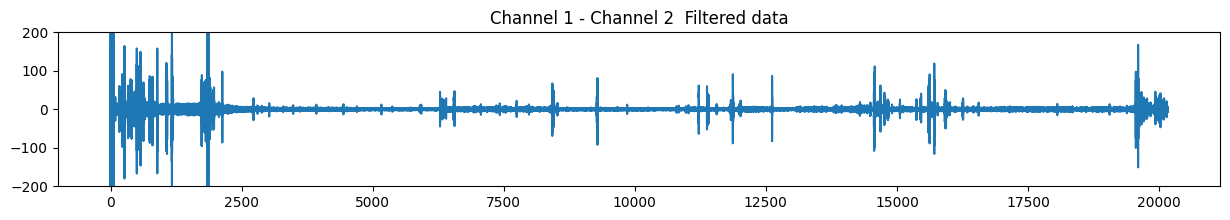

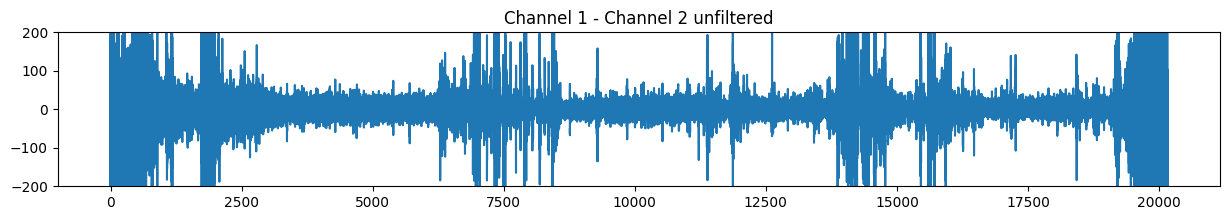

In [4]:
plt.figure(figsize=(15, 2))
plt.plot(resampled_times, prodigy_filtered_data_rs)
plt.title('Channel 1 - Channel 2  Filtered data')
plt.ylim(-200, 200)
# Plot the fft of the data
plt.figure(figsize=(15, 2))
plt.plot(resampled_times, (prodigy_base_data_df[config.CHANNEL_1] - prodigy_base_data_df[config.CHANNEL_2])*1000000 )
plt.title('Channel 1 - Channel 2 unfiltered')
plt.ylim(-200, 200)

### Unpack IDUN data

In [5]:
idun_base_data, idun_filtered_data, idun_time_stamps = prepare_idun_data(idun_raw_data,config)

Text(0.5, 1.0, 'IDUN Highpassed data')

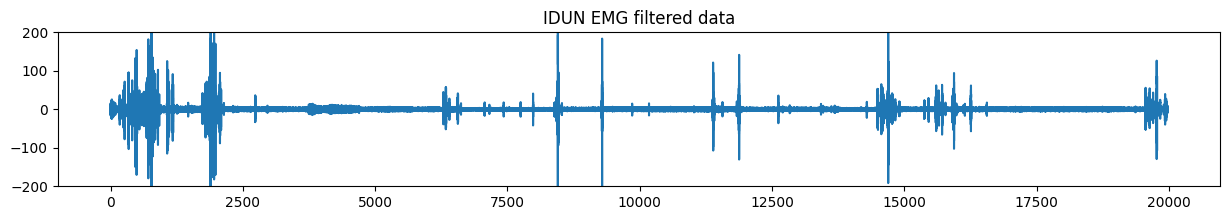

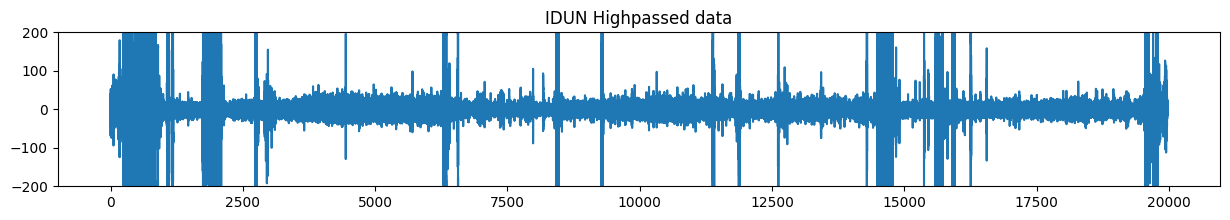

In [6]:
plt.figure(figsize=(15, 2))
plt.plot(idun_time_stamps, idun_filtered_data)
plt.ylim(-200, 200)
plt.title("IDUN EMG filtered data")

plt.figure(figsize=(15, 2))
plt.plot(idun_time_stamps, idun_base_data)
plt.ylim(-200, 200)
plt.title("IDUN Highpassed data")

### Make data same length

In [7]:
prodigy_clipped_data = copy.deepcopy(prodigy_filtered_data_rs)
idun_clipped_data = copy.deepcopy(idun_filtered_data)
idun_base_clipped_data = copy.deepcopy(idun_base_data)
prodigy_base_clipped_df = copy.deepcopy(prodigy_base_data_df)

# Find which one is longer and how much longer
if len(prodigy_clipped_data) > len(idun_clipped_data):
    diff = int(len(prodigy_clipped_data) - len(idun_clipped_data))
    prodigy_clipped_data = prodigy_clipped_data[int(diff/2):int(-diff/2)]
    prodigy_base_clipped_df = prodigy_base_clipped_df[int(diff/2):int(-diff/2)].reset_index(drop=True)
    print(f"Comparison data is longer with {diff/config.BASE_SAMPLE_RATE} seconds, cutting from end of Prodigy data")
else:
    diff = int(len(idun_clipped_data) - len(prodigy_clipped_data))
    idun_clipped_data = idun_clipped_data[int(diff/2):int(-diff/2)]
    idun_base_clipped_data = idun_base_clipped_data[int(diff/2):int(-diff/2)]
    print(f"IDUN data is longer with {diff/config.BASE_SAMPLE_RATE} seconds, cutting from end of IDUN data")
    
same_times = np.linspace(0, len(idun_clipped_data)/config.BASE_SAMPLE_RATE, len(idun_clipped_data))

Comparison data is longer with 190.08 seconds, cutting from end of Prodigy data


### DO MANUAL SHIFTING 

### ------------------------------------------------------------------------------------------------

In [8]:
SHIFT_SECONDS = -100
# save as txt file the shift amount in seconds
np.savetxt(os.path.join(folder,subject,night, 'shift_seconds.txt'), [SHIFT_SECONDS], delimiter=',')

### ------------------------------------------------------------------------------------------------

In [9]:

SHIFT = SHIFT_SECONDS*config.BASE_SAMPLE_RATE

# cut the lag_mean data from the start of idun_clipped_data if it is positive or from the start of  if negative
if SHIFT < 0:
    idun_pre_cut_data = idun_clipped_data[-SHIFT:]
    idun_pre_base_cut_data = idun_base_clipped_data[-SHIFT:]
    prodigy_pre_cut_data = prodigy_clipped_data[:-(-SHIFT)]
    prodigy_base_pre_cut_df = prodigy_base_clipped_df[:-(-SHIFT)].reset_index(drop=True)
else:
    idun_pre_cut_data = idun_clipped_data[:-(SHIFT)]
    idun_base_pre_cut_data = idun_base_clipped_data[:-(SHIFT)]
    prodigy_pre_cut_data = prodigy_clipped_data[SHIFT:]
    prodigy_base_pre_cut_df = prodigy_base_clipped_df[SHIFT:].reset_index(drop=True)

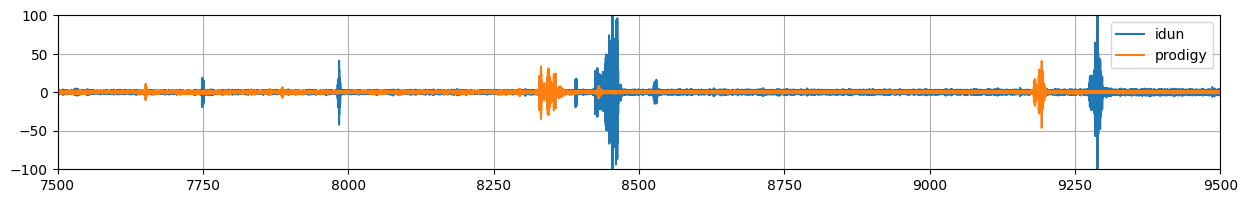

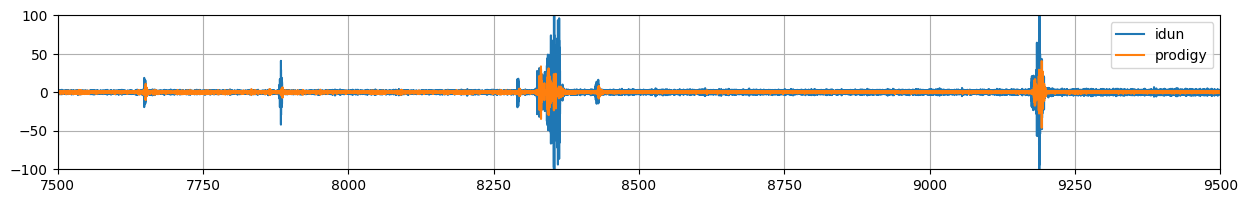

In [10]:
x_start = 7500
range_viz = 2000

plt.figure(figsize=(15, 2))
plt.plot(same_times,idun_clipped_data, label='idun')
plt.plot(same_times,0.5*prodigy_clipped_data, label='prodigy')
plt.xlim(x_start, x_start + range_viz)
plt.legend()
plt.ylim(-100,100)
plt.grid()


new_times = np.linspace(0, len(idun_pre_cut_data)/config.BASE_SAMPLE_RATE, len(idun_pre_cut_data))
plt.figure(figsize=(15, 2))
plt.plot(new_times,idun_pre_cut_data, label='idun')
plt.plot(new_times,0.5*prodigy_pre_cut_data, label='prodigy')
plt.xlim(x_start, x_start + range_viz)
plt.legend()
plt.ylim(-100,100)
plt.grid()


### Calculate lag

In [11]:
# extract only the first 1000 seconds
prodigy_clipped_temp_data = copy.deepcopy(prodigy_pre_cut_data)
idun_clipped_temp_data = copy.deepcopy(idun_pre_cut_data)

search_size = config.FIRST_LAG_EPOCH_SIZE

prodigy_epochs = epoch_data(prodigy_clipped_temp_data, search_size)
idun_epochs = epoch_data(idun_clipped_temp_data, search_size)
# extract only the f

In [12]:
correlation_arr, max_corr_arr, lag_arr = calculate_epochs_lag(prodigy_epochs, idun_epochs)
lag_arr_copy = lag_arr[1:].copy()

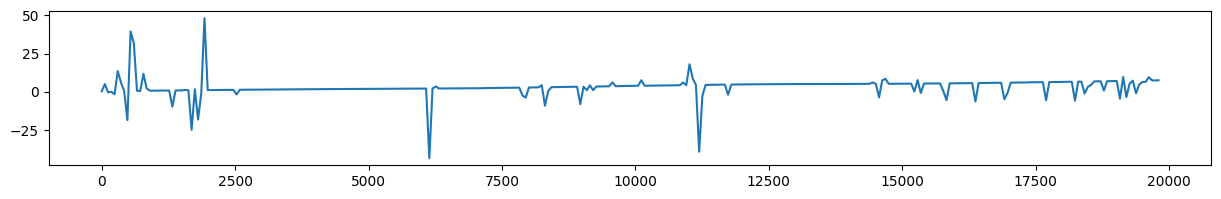

In [13]:

plt.figure(figsize=(15, 2))
# create a time array based on config.FIRST_LAG_EPOCH_SIZE and length of lag_arr_copy
plot_time_arr = np.linspace(0, len(lag_arr_copy)*config.FIRST_LAG_EPOCH_SIZE, len(lag_arr_copy))
# convert  to seconds
plot_time_arr = plot_time_arr/config.BASE_SAMPLE_RATE
plt.plot(plot_time_arr,np.array(lag_arr_copy)/250)

### Cut based on first analysis

In [14]:
lag_arr = np.array(lag_arr)
lag_initial = lag_arr[:20]
lag_initial = remove_outliers(lag_initial)
lag_mean = lag_initial[0]

# cut the lag_mean data from the start of idun_clipped_data if it is positive or from the start of  if negative
if lag_mean < 0:
    idun_cut_data = idun_pre_cut_data[-lag_mean:]
    idun_base_cut_data = idun_pre_base_cut_data[-lag_mean:]
    prodigy_cut_data = prodigy_pre_cut_data[:-(-lag_mean)]
    prodigy_base_cut_df = prodigy_base_pre_cut_df[:-(-lag_mean)].reset_index(drop=True)
else:
    idun_cut_data = idun_pre_cut_data[:-(lag_mean)]
    idun_base_cut_data = idun_pre_base_cut_data[:-(lag_mean)]
    prodigy_cut_data = prodigy_pre_cut_data[lag_mean:]
    prodigy_base_cut_df = prodigy_base_pre_cut_df[lag_mean:].reset_index(drop=True)

lag_mean:  0.188


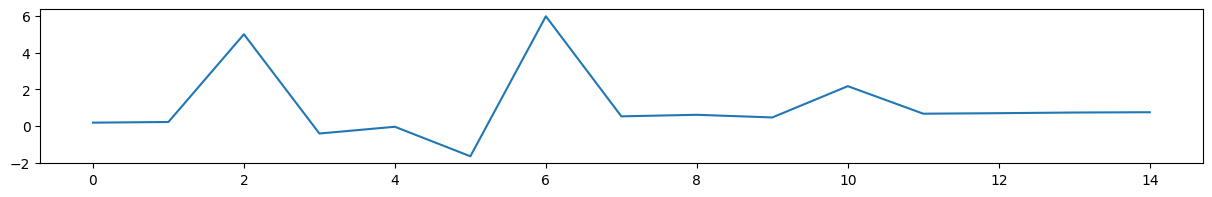

In [15]:
# plot the data
plt.figure(figsize=(15, 2))
plt.plot(lag_initial/250, label='idun')
print('lag_mean: ', lag_mean/250)

/Users/waddaben/.local/share/virtualenvs/idn-sync-data-pWEap7XJ/lib/python3.11/site-packages/IPython/core/events.py:93: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/waddaben/.local/share/virtualenvs/idn-sync-data-pWEap7XJ/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


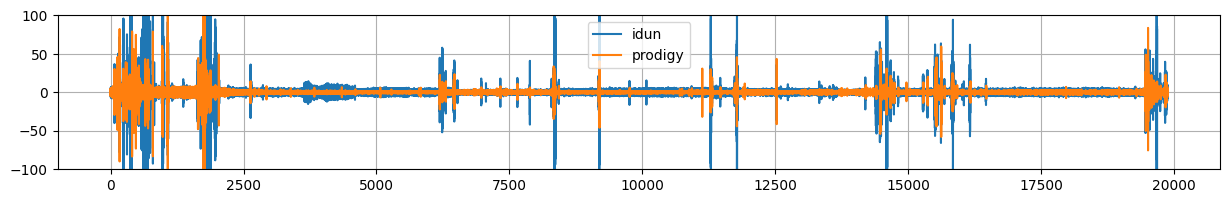

In [16]:
# plot the data
plt.figure(figsize=(15, 2))
time_seconds = np.arange(len(idun_cut_data))/config.BASE_SAMPLE_RATE
plt.plot(time_seconds,idun_cut_data, label='idun')
plt.plot(time_seconds,0.5*prodigy_cut_data, label='prodigy')
plt.legend()
plt.ylim(-100,100)
plt.grid()

### Do a more fine grained sync

In [17]:
cutted_prodigy_epochs = epoch_data(prodigy_cut_data, config.SECOND_LAG_EPOCH_SIZE)
cutted_idun_epochs = epoch_data(idun_cut_data, config.SECOND_LAG_EPOCH_SIZE)

In [18]:
fine_correlation_arr, fine_max_corr_arr, fine_lag_arr = calculate_epochs_lag(cutted_prodigy_epochs, cutted_idun_epochs)

(-1.0, 8.0)

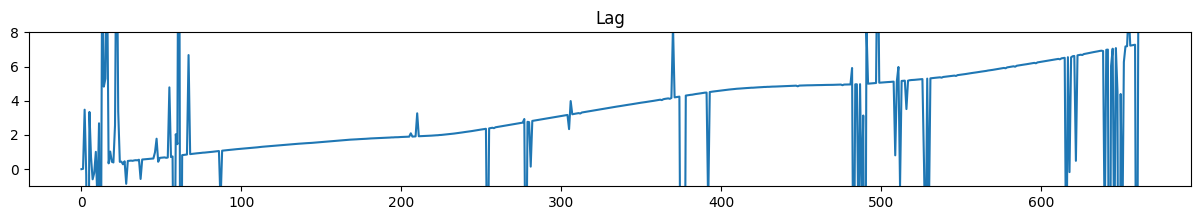

In [19]:
fine_lag_arr_copy = fine_lag_arr.copy()
plt.figure(figsize=(15, 2))
plt.plot(np.array(fine_lag_arr_copy)/250)
plt.title('Lag')
plt.ylim(-1,8)

### Do some cleaning on lag estimation

### ------------------------------------------------------------------------------------------------

In [20]:
CORRELATION_STRICTNESS = 0.5
# save as txt file the correlation strictness
np.savetxt(os.path.join(folder,subject,night, 'correlation_strictness.txt'), [CORRELATION_STRICTNESS], delimiter=',')

### ------------------------------------------------------------------------------------------------

In [21]:
cleaned_fine_lag_arr = replace_outliers(fine_lag_arr_copy, strictness = CORRELATION_STRICTNESS)

(-1.0, 8.0)

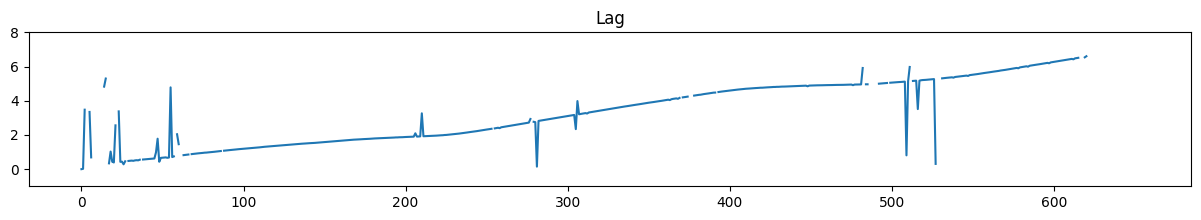

In [22]:
plt.figure(figsize=(15, 2))
plt.plot(np.array(cleaned_fine_lag_arr)/250)
plt.title('Lag')
plt.ylim(-1,8)

### Fit a curve to the data

### ------------------------------------------------------------------------------------------------

In [40]:
POLYNOMIAL_DEGREE = 2
# Save the polynomial degree to a txt file
np.savetxt(os.path.join(folder,subject,night, 'polynomial_degree.txt'), [POLYNOMIAL_DEGREE], delimiter=',')

### ------------------------------------------------------------------------------------------------

In [41]:
# original_raw_lag = copy.deepcopy(cleaned_fine_lag_arr)
# x_axis_lag = np.arange(len(cleaned_fine_lag_arr)).reshape(-1, 1)
# x_axis_lag_copy = x_axis_lag.copy()
# # find where y is not nan
# not_nan_idx = np.where(~np.isnan(original_raw_lag))[0]
# original_raw_lag = original_raw_lag[not_nan_idx]
# x_axis_lag = x_axis_lag[not_nan_idx]
# # Transform the features to 2nd degree polynomial features
# poly = PolynomialFeatures(degree=POLYNOMIAL_DEGREE)
# X_poly = poly.fit_transform(x_axis_lag)
# # Create a LinearRegression model and fit it to the polynomial features
# reg = LinearRegression().fit(X_poly, original_raw_lag)
# # Predict values
# X_new_poly = poly.transform(x_axis_lag_copy)
# linear_regression_lag = reg.predict(X_new_poly)
linear_regression_lag = polynomial_regression_on_lag(cleaned_fine_lag_arr,POLYNOMIAL_DEGREE)


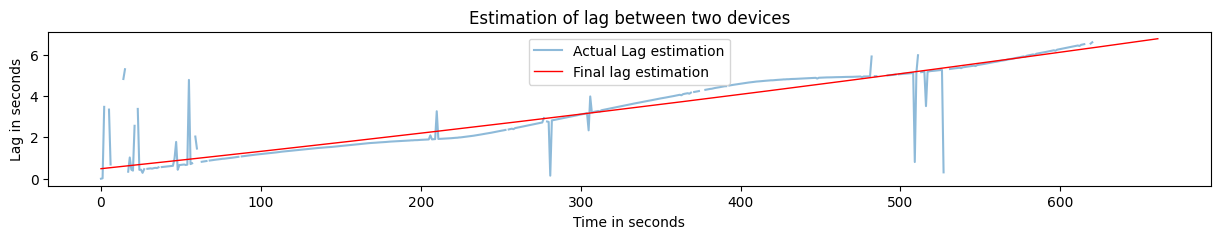

In [42]:
# Plotting the regression curve
plt.figure(figsize=(15, 2))
plt.plot(cleaned_fine_lag_arr/250, label='Actual Lag estimation', alpha=0.5)
plt.plot(linear_regression_lag/250, "r-", label="Final lag estimation", linewidth=1)
plt.title("Estimation of lag between two devices")
plt.xlabel("Time in seconds")
plt.ylabel("Lag in seconds")
plt.legend()
plt.show()

### Create linear knots

In [43]:
x_axis_simulated = np.linspace(0, len(linear_regression_lag)-1, len(linear_regression_lag))  # This will be 0 to 718
x_knots = np.linspace(0, len(linear_regression_lag)-1, config.TOTAL_LINEAR_SEGMENTS+1)
y_knots = linear_regression_lag[(x_knots).astype(int)]  # Directly get the y-values from y_pred

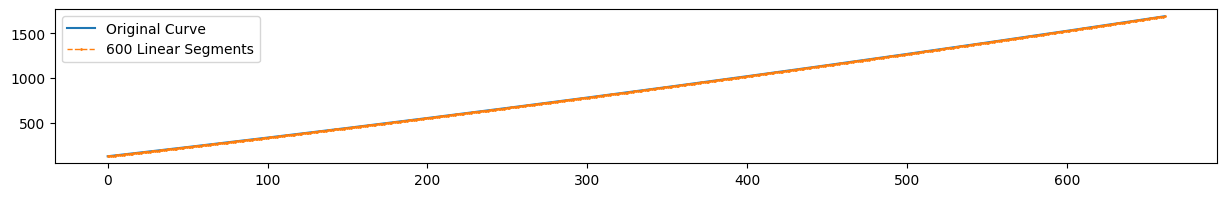

In [44]:
# Plot
plt.figure(figsize=(15, 2))
plt.plot(x_axis_simulated, linear_regression_lag, label='Original Curve')
plt.plot(x_knots, y_knots, label=f'{config.TOTAL_LINEAR_SEGMENTS} Linear Segments', linestyle='--', marker='o', linewidth=1, markersize=1)
plt.legend()
plt.show()

### Use the Linear lines to estimate the difference in sampling rates and apply

In [45]:
point_size = config.SECOND_LAG_EPOCH_SIZE
adjustment_epoch_size = int(len(prodigy_cut_data)/config.TOTAL_LINEAR_SEGMENTS)
lag_positions = np.arange(0, len(prodigy_cut_data), adjustment_epoch_size)
cumulative_lags = y_knots.astype(int)
lag_sizes = np.diff(cumulative_lags)

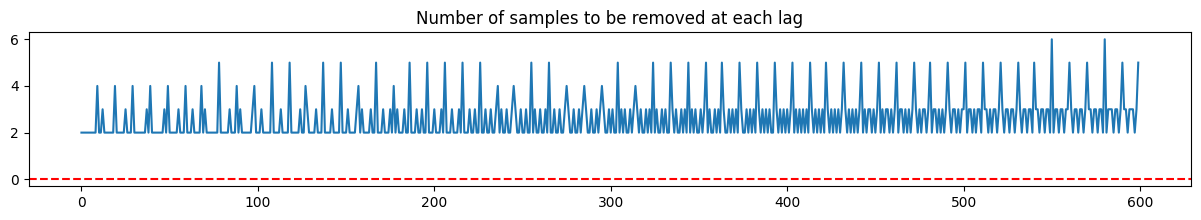

In [46]:
plt.figure(figsize=(15, 2))
plt.plot(lag_sizes)
plt.title("Number of samples to be removed at each lag")
plt.axhline(y=0, color='r', linestyle='--')

In [47]:
dataset2 = copy.deepcopy(prodigy_cut_data)
base_dataset2 = copy.deepcopy(prodigy_base_cut_df)
dataset2_list = dataset2.tolist()


for i in range(len(lag_positions)):
    start_index = lag_positions[i]
    # Calculate how many elements to replace with np.nan
    if i == 0:
        n_replace = int(cumulative_lags[i])
    else:
        n_replace = int(cumulative_lags[i] - cumulative_lags[i-1])
        
    for j in range(n_replace):
        if start_index+j < len(dataset2_list):
            dataset2_list[start_index+j] = np.nan
            base_dataset2.iloc[start_index+j] = np.nan

# Convert back to numpy array and remove np.nan values
adjusted_dataset2 = np.array(dataset2_list)
adjusted_dataset2 = adjusted_dataset2[~np.isnan(adjusted_dataset2)]

# Drop rows in base_dataset2 that contain NaN values
base_dataset2 = base_dataset2.dropna()

prodigy_adjusted_final_arr = copy.deepcopy(adjusted_dataset2)
prodigy_adjusted_base_final_df = copy.deepcopy(base_dataset2)

idun_adjusted_final_arr = copy.deepcopy(idun_cut_data)
idun_adjusted_base_final_arr = copy.deepcopy(idun_base_cut_data)


# Cut from the end of the longer dataset
if len(prodigy_adjusted_final_arr) > len(idun_cut_data):
    prodigy_adjusted_final_arr = prodigy_adjusted_final_arr[:len(idun_adjusted_final_arr)]
    prodigy_adjusted_base_final_df = prodigy_adjusted_base_final_df[:len(idun_adjusted_final_arr)].reset_index(drop=True)
    
else:
    idun_adjusted_final_arr = idun_adjusted_final_arr[:len(prodigy_adjusted_final_arr)]
    idun_adjusted_base_final_arr = idun_adjusted_base_final_arr[:len(prodigy_adjusted_final_arr)]

print(len(prodigy_adjusted_final_arr), len(idun_adjusted_final_arr))


4965741 4965741


In [48]:
final_prodigy_epochs = epoch_data(prodigy_adjusted_final_arr, config.SECOND_LAG_EPOCH_SIZE)
final_idun_epochs = epoch_data(idun_adjusted_final_arr, config.SECOND_LAG_EPOCH_SIZE)

In [49]:
final_correlation_arr, final_max_corr_arr, final_lag_arr = calculate_epochs_lag(final_prodigy_epochs, final_idun_epochs)

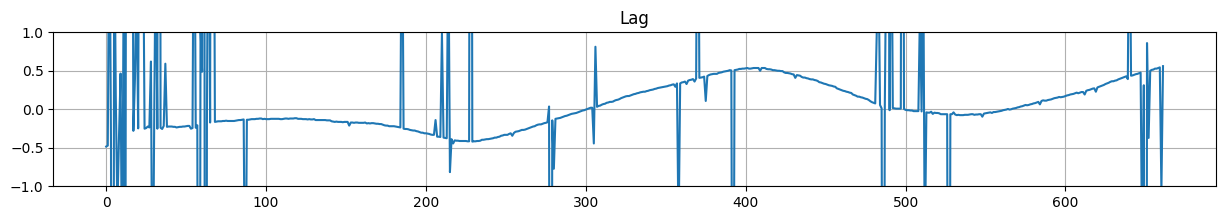

In [50]:
final_lag_arr_copy = final_lag_arr.copy()
plt.figure(figsize=(15, 2))
plt.plot(np.array(final_lag_arr)/250)
plt.title('Lag')
plt.ylim(-1,1)
plt.grid()

### Clean the lags

In [51]:
cleaned_final_lag_arr = replace_outliers(final_lag_arr_copy)
# rfind where the values are nan
nan_idx = np.argwhere(np.isnan(cleaned_final_lag_arr))
# remove the nan values
mean_final_lag = np.mean(np.delete(cleaned_final_lag_arr, nan_idx, axis=0))

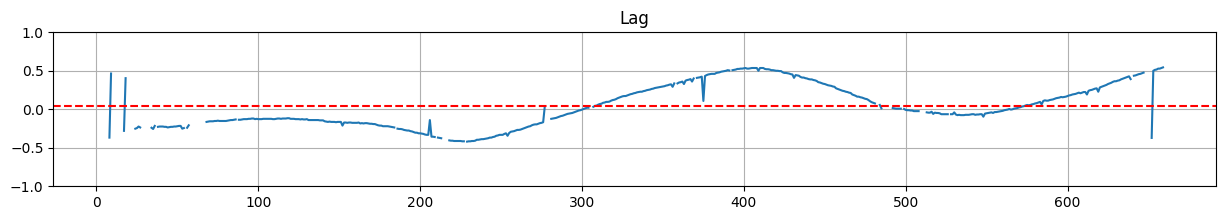

In [52]:
plt.figure(figsize=(15, 2))
plt.plot(np.array(cleaned_final_lag_arr)/250)
# plot the mean_final_lag as a horizontal line
plt.axhline(y=mean_final_lag/250, color='r', linestyle='--')
plt.title('Lag')
plt.ylim(-1,1)
plt.grid()

### Remove this final shift

In [53]:
# remove mean amount from start of idun data if negative else from start of prodigy data if positive
if mean_final_lag > 0:
    shifted_final_prodigy_arr = prodigy_adjusted_final_arr[int(mean_final_lag):]
    shifted_final_prodigy_base_df = prodigy_adjusted_base_final_df[int(mean_final_lag):].reset_index(drop=True)

    shifted_final_idun_arr = idun_adjusted_final_arr[:-int(mean_final_lag)]
    shifted_final_idun_base_arr = idun_adjusted_base_final_arr[:-int(mean_final_lag)]
else:
    shifted_final_prodigy_arr = prodigy_adjusted_final_arr[:-(-int(mean_final_lag))]
    shifted_final_prodigy_base_df = prodigy_adjusted_base_final_df[:-(-int(mean_final_lag))].reset_index(drop=True)

    shifted_final_idun_arr = idun_adjusted_final_arr[-int(mean_final_lag):]
    shifted_final_idun_base_arr = idun_adjusted_base_final_arr[-int(mean_final_lag):]


In [54]:
shifted_final_prodigy_epochs = epoch_data(shifted_final_prodigy_arr, config.SECOND_LAG_EPOCH_SIZE)
shifted_final_idun_epochs = epoch_data(shifted_final_idun_arr, config.SECOND_LAG_EPOCH_SIZE)
shifted_final_correlation_arr, shifted_final_max_corr_arr, shifted_final_lag_arr = calculate_epochs_lag(shifted_final_prodigy_epochs, shifted_final_idun_epochs)

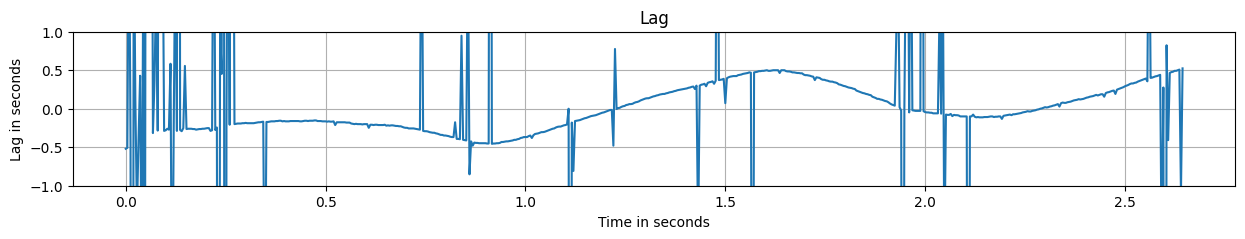

In [55]:

plt.figure(figsize=(15, 2))
# create time array knowing the each epoch has size of config.SECOND_LAG_EPOCH_SIZE and should be as long as shifted_final_lag_arr
time_seconds = np.arange(len(shifted_final_idun_arr))/config.BASE_SAMPLE_RATE
# make the time array as long as shifted_final_lag_arr
time_seconds = time_seconds[:len(shifted_final_lag_arr)]
plt.plot(time_seconds,np.array(shifted_final_lag_arr)/250)
plt.title('Lag')
plt.xlabel('Time in seconds')
plt.ylabel('Lag in seconds')
plt.ylim(-1,1)
plt.grid()
# save image of lag
plt.savefig(os.path.join(folder,subject,night,f'{subject}_{night}_lag.png'))

### Plot final filtered data

/Users/waddaben/.local/share/virtualenvs/idn-sync-data-pWEap7XJ/lib/python3.11/site-packages/IPython/core/events.py:93: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/waddaben/.local/share/virtualenvs/idn-sync-data-pWEap7XJ/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


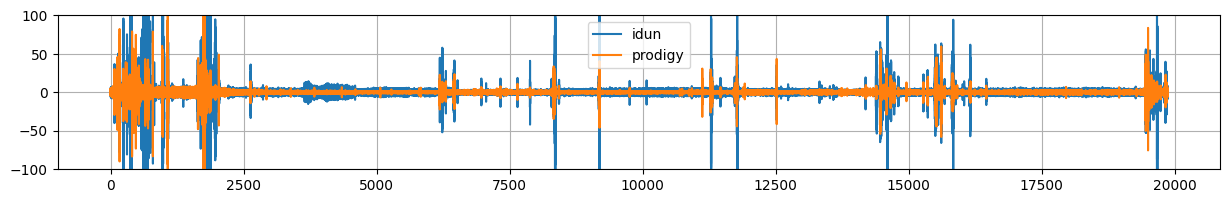

In [56]:
plt.figure(figsize=(15, 2))
# create a seconds axis
time_seconds = np.arange(len(shifted_final_idun_arr))/config.BASE_SAMPLE_RATE
plt.plot(time_seconds,shifted_final_idun_arr, label='idun')
plt.plot(time_seconds,0.5*shifted_final_prodigy_arr, label='prodigy')
plt.legend()
plt.ylim(-100,100)
plt.grid()

### Final validation, plot final raw data

(4965732, 8)
(4965732,)


/var/folders/z6/9xfx7slx70vby8pq0t9tcmk00000gn/T/ipykernel_60357/1584525763.py:32: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(os.path.join(folder,subject,night,f'{subject}_{night}_raw.png'))
/var/folders/z6/9xfx7slx70vby8pq0t9tcmk00000gn/T/ipykernel_60357/1584525763.py:43: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(os.path.join(folder,subject,night,f'{subject}_{night}_filtered.png'))


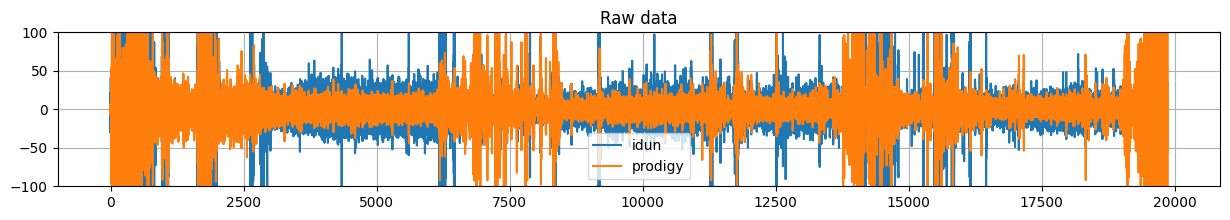

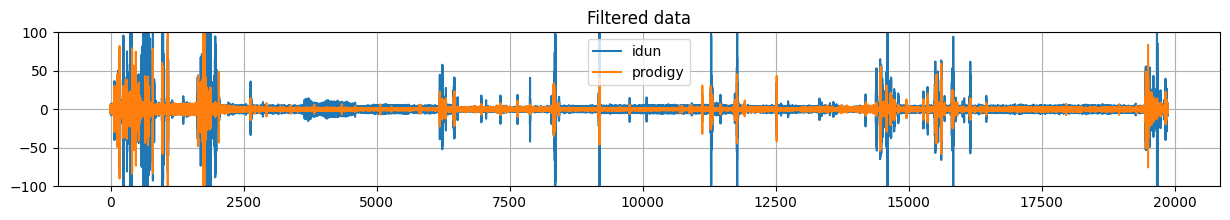

In [57]:
print(shifted_final_prodigy_base_df.shape)
print(shifted_final_idun_base_arr.shape)

prodigy_channel_1_data = np.array(shifted_final_prodigy_base_df[config.CHANNEL_1])
prodigy_channel_2_data = np.array(shifted_final_prodigy_base_df[config.CHANNEL_2])
# minus right eye from left eye
prodigy_channel_1_minus_2 = prodigy_channel_1_data - prodigy_channel_2_data
prodigy_channel_1_minus_2 = (
    prodigy_channel_1_minus_2 * 1000000
)  # To get the data to same scale as ours, v to uv

prodigy_filtered = do_bandpass(
    prodigy_channel_1_minus_2,
    [config.FILTER_RANGE[0], config.FILTER_RANGE[1]],
    config.BASE_SAMPLE_RATE,
)

idun_filtered = do_bandpass(
    shifted_final_idun_base_arr,
    [config.FILTER_RANGE[0], config.FILTER_RANGE[1]],
    config.BASE_SAMPLE_RATE,
)


plt.figure(figsize=(15, 2))
time_seconds = np.arange(len(shifted_final_idun_base_arr))/config.BASE_SAMPLE_RATE
plt.plot(time_seconds,shifted_final_idun_base_arr, label='idun')
plt.plot(time_seconds,0.5*prodigy_channel_1_minus_2, label='prodigy')
plt.legend()
plt.ylim(-100,100)
plt.title("Raw data")
plt.savefig(os.path.join(folder,subject,night,f'{subject}_{night}_raw.png'))
plt.grid()


plt.figure(figsize=(15, 2))
time_seconds = np.arange(len(idun_filtered))/config.BASE_SAMPLE_RATE
plt.plot(time_seconds,idun_filtered, label='idun')
plt.plot(time_seconds,0.5*prodigy_filtered, label='prodigy')
plt.legend()
plt.ylim(-100,100)
plt.title("Filtered data")
plt.savefig(os.path.join(folder,subject,night,f'{subject}_{night}_filtered.png'))
plt.grid()





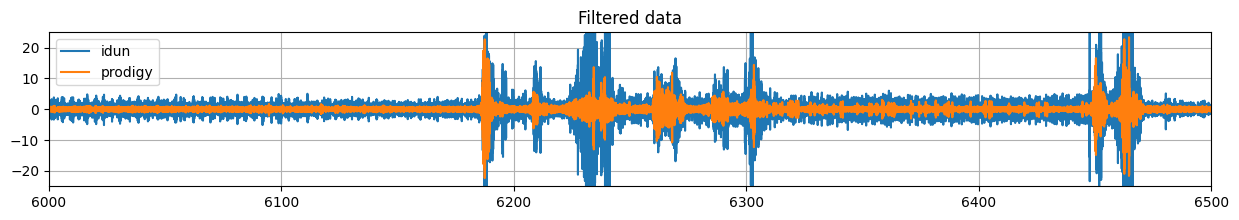

In [58]:
plt.figure(figsize=(15, 2))
time_seconds = np.arange(len(idun_filtered))/config.BASE_SAMPLE_RATE
plt.plot(time_seconds,idun_filtered, label='idun')
plt.plot(time_seconds,0.5*prodigy_filtered, label='prodigy')
plt.legend()
plt.xlim(6000, 6500)
plt.ylim(-25,25)
plt.title("Filtered data")
plt.grid()
plt.savefig(os.path.join(folder,subject,night,f'{subject}_{night}_filtered_zoom.png'))


### Combine Dataframes

In [97]:
# create a time array based on config.BASE_SAMPLE_RATE and length of prodigy_filtered
time_array = np.linspace(0, len(shifted_final_idun_base_arr)/config.BASE_SAMPLE_RATE, len(shifted_final_idun_base_arr))
# copy the shifted_final_prodigy_base_df
synced_base_df_copy = copy.deepcopy(shifted_final_prodigy_base_df)
# add shifted_final_idun_base_arr as "IDUN" column to prodigy_base_df_copy
synced_base_df_copy["IDUN"] = shifted_final_idun_base_arr
# make index of prodigy_base_df_copy as time_array
synced_base_df_copy.index = time_array

# save the dataframe as csv, and add a header indicating the sampling rate
save_path = os.path.join(folder,subject,night,f'{subject}_{night}_synced_data.csv')
synced_base_df_copy.to_csv(save_path, index=True)